In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
# import seaborn as sns
# sns.set() # Setting seaborn as default style even if use only matplotlib
import GPy
import argparse
import sys 
import os
os.environ['PYTHONHASHSEED'] = '0'
import seaborn as sns
sns.set_style("white")
plt.rcParams.update({'font.size': 12})

In [2]:
seed = 20

In [3]:
resultdir = os.path.join(os.getcwd(), 'SGPR_results' ,str(seed)+'-seed') 

if not os.path.exists(resultdir):
    os.makedirs(resultdir)

# Toy prob

In [4]:
np.random.seed(seed=seed)

In [5]:
g = lambda x: np.sin(8.0 * np.pi * x)
f = lambda x: (x - np.sqrt(2.0)) * g(x) ** 2
std_dev_g = 0.25
std_dev_f = 0.20

In [6]:
''' Test data '''
X_p = np.linspace(0.0, 1.0, 150)[:,None]
z_p = g(X_p) + std_dev_g * np.random.RandomState(seed=seed).randn(*g(X_p).shape) # inexpensive measurements
y_p = f(X_p) + std_dev_f * np.random.RandomState(seed=seed).randn(*f(X_p).shape) # expensive measurements

(25, 1) (25, 1) (25, 1)


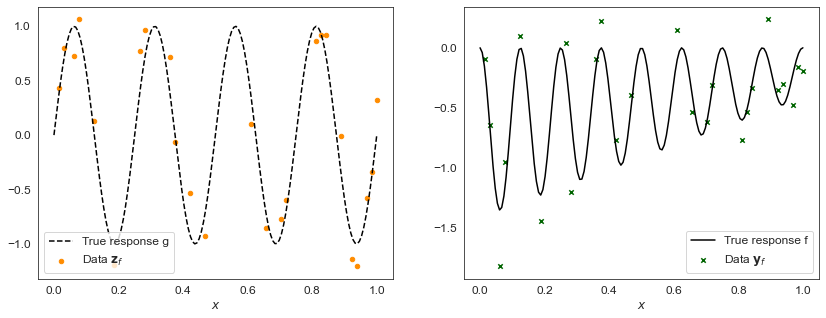

In [7]:
''' Train data '''
N_g = 65
N_f = 25

X_g = np.linspace(0, 1, N_g)[:,None]
z_g = g(X_g) + std_dev_g * np.random.RandomState(seed=seed).randn(*g(X_g).shape)

# for nested data
perm = np.random.RandomState(seed=seed).permutation(N_g)
X_f = X_g[perm[0:N_f]]
z_f = z_g[perm[0:N_f]]
y_f = f(X_f) + std_dev_f * np.random.RandomState(seed=seed).randn(*f(X_f).shape)

print (X_f.shape, z_f.shape, y_f.shape)

plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(X_p, g(X_p), 'k--', label="True response g")
plt.scatter(X_f, z_f, s=20, color='darkorange', marker='o', label=r"Data $\mathbf{z}_f$")
plt.xlabel('$x$', fontsize=12)
# plt.ylabel('$y$', fontsize=12)
plt.legend(loc="best", fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(X_p, f(X_p), 'k-', label="True response f")
plt.scatter(X_f, y_f, s=20, color='darkgreen', marker='x', label=r"Data $\mathbf{y}_f$")
plt.xlabel('$x$', fontsize=12)
# plt.ylabel('$y$', fontsize=12)
plt.legend(loc="best", fontsize=12)

plt.savefig(os.path.join(resultdir,str(seed)+'-'+'data.pdf'),dpi=300)
plt.show()
plt.close()

## SGPR

In this Case, we are going to build GP_f model

using {X=[X_f,z_f], Y=y_f}

where z_f, y_f are noisy data


In [8]:
print ('Building GP_f between [X_f,z_f] and y_f')
X_all = np.hstack((X_f,z_f))
kf = GPy.kern.RBF(X_all.shape[1], ARD=True)
mf = GPy.models.GPRegression(X_all, y_f, kf)
mf.Gaussian_noise.variance.constrain_fixed(std_dev_f**2)
mf.optimize_restarts()
print(mf)
print(mf[".*Gaussian_noise"])

Building GP_f between [X_f,z_f] and y_f
Optimization restart 1/10, f = 22.041602129610816
Optimization restart 2/10, f = 23.868952015156573
Optimization restart 3/10, f = 22.041602129629638


 /Users/sharmila/anaconda3/envs/py36_tf2/lib/python3.6/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/10, f = 22.73220930553468
Optimization restart 5/10, f = 22.73220930556058
Optimization restart 6/10, f = 22.73220930553712
Optimization restart 7/10, f = 25.57311643786958
Optimization restart 8/10, f = 22.732209305534177
Optimization restart 9/10, f = 25.573116437871853
Optimization restart 10/10, f = 22.041602129635635

Name : GP regression
Objective : 22.041602129610816
Number of Parameters : 4
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |  0.40020687248337505  |      +ve      |        
  rbf.lengthscale          |                 (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.04000000000000001  |   +ve fixed   |        
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.04000000  |   +ve fixed   |        


In [9]:
print('GP Predictions') # posterior (f*|y)
postsam_f = mf.posterior_samples_f(np.hstack((X_p, z_p)), size=1000) # posterior_samples_f gives epistemic uncertainity only
print (postsam_f.shape)

mupred_f, varpred_f = np.mean(postsam_f, axis=2), np.var(postsam_f, axis=2)

GP Predictions
(150, 1, 1000)


GP Predictions plots
************************************************
y MRel.AE wrt truth: inf
y MAE wrt truth: 0.2519655924288007
************************
y MRel.AE: 17.29302989312501
y MAE: 0.2778495837709441
************************************************


 /Users/sharmila/anaconda3/envs/py36_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:divide by zero encountered in true_divide


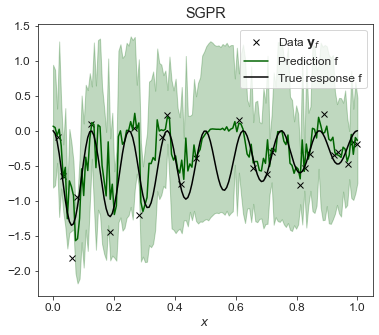

In [10]:
from sklearn.metrics import mean_absolute_error
def mean_relative_absolute_error(y_true, y_pred): 
    return np.mean( np.abs((y_pred-y_true)/y_true) )

print('GP Predictions plots')
y_MRelAE_wrt_truth = mean_relative_absolute_error( f(X_p), mupred_f )
y_MAE_wrt_truth = mean_absolute_error( f(X_p),  mupred_f )

y_MRelAE = mean_relative_absolute_error( y_p, mupred_f )
y_MAE = mean_absolute_error( y_p,  mupred_f )

print ('************************************************')
print ('y MRel.AE wrt truth: '+str(y_MRelAE_wrt_truth))
print ('y MAE wrt truth: '+str(y_MAE_wrt_truth ))

print ('************************')

print ('y MRel.AE: '+str(y_MRelAE))
print ('y MAE: '+str(y_MAE))
print ('************************************************')


fig, ax = plt.subplots(figsize=(6,5))
Xdata = [X_f]
Ydata = [y_f]
Yp = [mupred_f]
Vp = [varpred_f]
markers = ['x']
colors = ['darkgreen']

for x, y, yp, vp, c, mk in zip(Xdata, Ydata, Yp, Vp, colors, markers):
    ax.plot(x, y, mk, color='black', markeredgewidth=1)
    ax.plot(X_p, yp, color=c)
    sp = np.sqrt(vp)
    lp = yp - 1.96 * sp
    up = yp + 1.96 * sp
    ax.fill_between(X_p.flatten(), lp.flatten(), up.flatten(), color=c,
                    alpha=0.25)
ax.plot(X_p, f(X_p), 'k-')
ax.set_xlabel('$x$', fontsize=12)
# ax.set_ylabel('$y$')
plt.tick_params(bottom=True, left=True)
plt.legend([r"Data $\mathbf{y}_f$", 'Prediction f', 'True response f'], loc='best')
plt.title('SGPR')

plt.savefig(os.path.join(resultdir,str(seed)+'-'+'y_pred.pdf'),dpi=300)
plt.show()
plt.close()

## Diagnostic checks

If the model is correct i.e., if the statistics predicted by model is correct, then ECDF evaluated at the test data should follow a uniform distribution.


k_i ~ F (y_p_i) ~ U[0,1]

where y_p is output test data 

In [11]:
postsamples_f = postsam_f[:,0,:].T
print (postsamples_f.shape)

(1000, 150)


In [12]:
sigma_f = np.sqrt(mf.Gaussian_noise.variance.values[0])
print (sigma_f)

0.2


(1000, 150)
(150, 1)


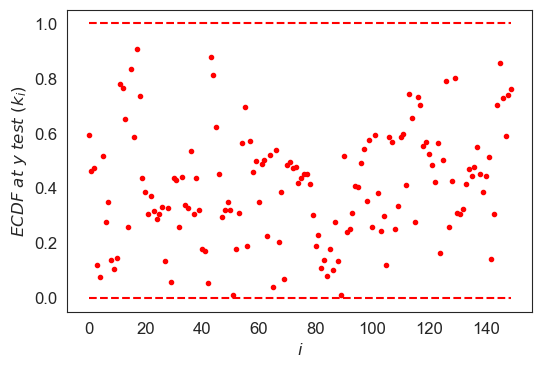

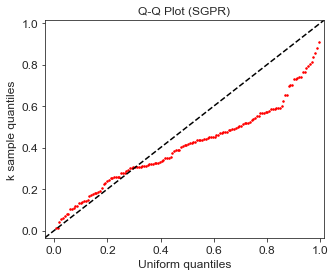

KstestResult(statistic=0.2613333333333334, pvalue=1.5821496736679992e-09)


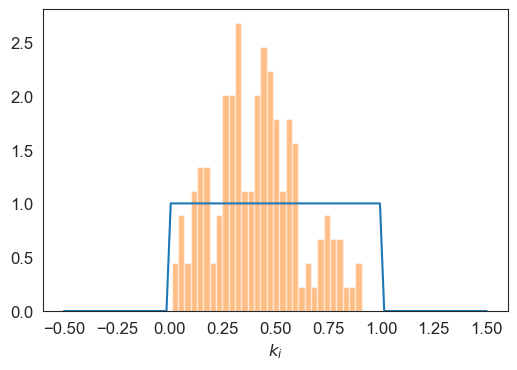

In [13]:
# predictive posterior (y*|y)
predpostsamples_f = np.zeros((postsamples_f.shape[0], postsamples_f.shape[1])) 
import pymc3 as pm
for i in range(predpostsamples_f.shape[0]):
    predpostsamples_f[i,:] = pm.Normal.dist(mu=postsamples_f[i,:], 
                                                sigma=sigma_f).random()
print (predpostsamples_f.shape)
print (y_p.shape)

# https://www.statsmodels.org/stable/generated/statsmodels.distributions.empirical_distribution.ECDF.html
from statsmodels.distributions.empirical_distribution import ECDF

ecdf_y_p = []
for i in range(y_p.shape[0]):
    ecdf = ECDF(predpostsamples_f[:,i]) # Build ECDF with all samples
    ecdf_y_p.append(ecdf(y_p[i])[0]) # CDF evaluated at test points
    
    
fig, ax = plt.subplots(dpi=100)
ax.plot(ecdf_y_p, 'o', color='red', markersize=3)
ax.plot(np.arange(y_p.shape[0]), 0.0 * np.ones(y_p.shape[0]), 'r--')
ax.plot(np.arange(y_p.shape[0]), 1.0 * np.ones(y_p.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$ECDF \ at \ y \ test \ (k_i)$');
plt.savefig(os.path.join(resultdir,str(seed)+'-'+'ECDF_at_y_test.pdf'),dpi=300)
plt.show()
plt.close()


import statsmodels.api as sm
import scipy.stats as st
import pylab
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5,4))
fig_ = sm.qqplot(np.asarray(ecdf_y_p), st.uniform, loc=0, scale=1, marker='.', markerfacecolor='r', markeredgecolor='r', markersize=3, alpha=1, ax=ax)
sm.qqline(fig_.axes[0], line='45', fmt='k--')
ax.set_title('Q-Q Plot (SGPR)', fontsize=12)
ax.set_xlabel('Uniform quantiles', fontsize=12)
ax.set_ylabel('k sample quantiles', fontsize=12)
ax.tick_params(bottom=True, left=True)
fig.savefig(os.path.join(resultdir,str(seed)+'-'+'q-q_plot_y_test.pdf'),dpi=300)
plt.show()
plt.close()

# https://www.geeksforgeeks.org/ml-kolmogorov-smirnov-test/
res = st.kstest(ecdf_y_p,"uniform")    
print(res) 

ks = ecdf_y_p
fig, ax = plt.subplots(dpi=100)
ps = np.linspace(-0.5, 1.5, 100)
ax.plot(ps, st.uniform.pdf(ps))
ax.hist(ks, density=True, alpha=0.5, bins = 30)
ax.set_xlabel('$k_i$')
plt.savefig(os.path.join(resultdir,str(seed)+'-'+'k_i_y_test.pdf'),dpi=300)
plt.show()
plt.close()

In [14]:
print ('Required outputs:')
print ('Seed: '+str(seed)) 
print ('y MRel.AE wrt truth: '+str(y_MRelAE_wrt_truth))
print ('y MAE wrt truth: '+str(y_MAE_wrt_truth ))
print ('y KS test: '+str(res.statistic))

Required outputs:
Seed: 20
y MRel.AE wrt truth: inf
y MAE wrt truth: 0.2519655924288007
y KS test: 0.2613333333333334
